In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image

In [2]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[['LifeSquare', 'Healthcare_1']].median()
        
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
        
        # 2. Выбросы (outliers)
        df.loc[df['Rooms'] > 5, 'Rooms'] = 5
        df.loc[df['Square'] > 200, 'Square'] = 200
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = np.quantile(df['LifeSquare'], 0.75)
        df.loc[df['LifeSquare'] < 20, 'LifeSquare'] = df['Square'] * 0.75
        df.loc[(df['KitchenSquare'] > df['LifeSquare']) | (df['KitchenSquare'] < 5), 'KitchenSquare'] = df['Square'] * 0.25
        df.loc[df['HouseFloor'] > 50, 'HouseFloor'] = 50
        df.loc[df['HouseFloor'] < 3, 'HouseFloor'] = 3
        df.loc[df['Floor'] > df['HouseFloor'] , 'Floor'] = df['HouseFloor']
 
        ######################################
        
        # 3. Новые фичи (features)
        
        #Доля жилой площади в общей площади
        df['LifeSquare_share'] = df['LifeSquare'] / df['Square']
        
        #Доля комнат в общей площади
        df['count_LifeSquare'] = df['Rooms'] / df['LifeSquare']
        
        
        ########################################3
#         binary_to_numbers = {'A': 0, 'B': 1}

#         df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
#         df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
#         df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)
        
        
#         df_cat = df.groupby(['Ecology_2', 'Ecology_3', 'Shops_2'], as_index=False).median()[['Ecology_2', 'Ecology_3', 'Shops_2', 'Square']]
#         df_cat = pd.DataFrame(df_cat)
#         df_cat.rename(columns={'Square': 'median_square'}, inplace=True)
#         df = df.merge(df_cat, on=['Ecology_2', 'Ecology_3', 'Shops_2'])
        
        return df
    
    def target_enc(self, df):
#         self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({df1['Price']:'median'})\
#                 .rename(columns={'Price':'median_price'})
#         df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

        return df

In [3]:
def age_to_cat(X):

    X['age_cat'] = 0

    X.loc[(2020-X['HouseYear']) <= 5, 'age_cat'] = 1  
    X.loc[(2020-X['HouseYear'] > 5) & (2020-X['HouseYear'] <= 10), 'age_cat'] = 2
    X.loc[(2020-X['HouseYear'] > 10) & (2020-X['HouseYear'] <= 25), 'age_cat'] = 3
    X.loc[(2020-X['HouseYear']) > 25, 'age_cat'] = 4

    return X

In [4]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'

In [5]:
df = pd.read_csv(DATASET_PATH)

pipe = DataPipeline()
pipe.fit(df)
df = pipe.transform(df)
df = pipe.target_enc(df)

age_to_cat(df)
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [6]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_share,count_LifeSquare,age_cat
0,11809,27,3.0,115.027311,32.781260,10.000000,4.0,10.0,2014,0.075424,...,3097,0,900.0,0,0,B,305018.871089,0.284987,0.091516,2
1,3013,22,1.0,39.832524,23.169223,8.000000,7.0,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,0.581666,0.043161,4
2,8215,1,3.0,78.342215,47.671972,10.000000,2.0,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,0.608509,0.062930,4
3,2352,1,1.0,40.409907,32.781260,10.102477,10.0,22.0,1977,0.007122,...,264,0,900.0,0,1,B,168106.007630,0.811218,0.030505,4
4,13866,94,2.0,64.285067,38.562517,9.000000,16.0,16.0,1972,0.282798,...,8667,2,900.0,0,6,B,343995.102962,0.599867,0.051864,4


In [7]:
matplotlib.rcParams.update({'font.size': 14})

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [10]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.64 MB
Memory usage after optimization is: 0.60 MB
Decreased by 63.4%


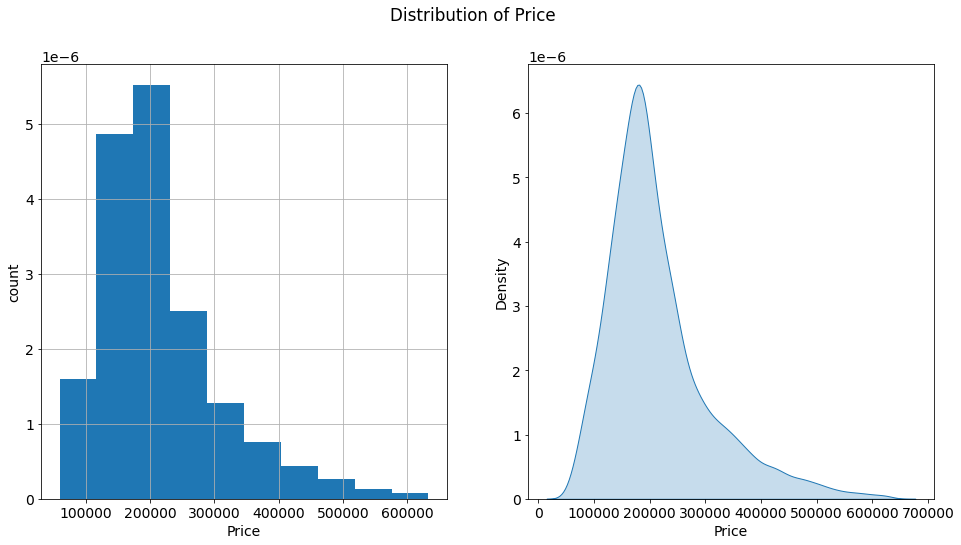

In [11]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=True)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [12]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

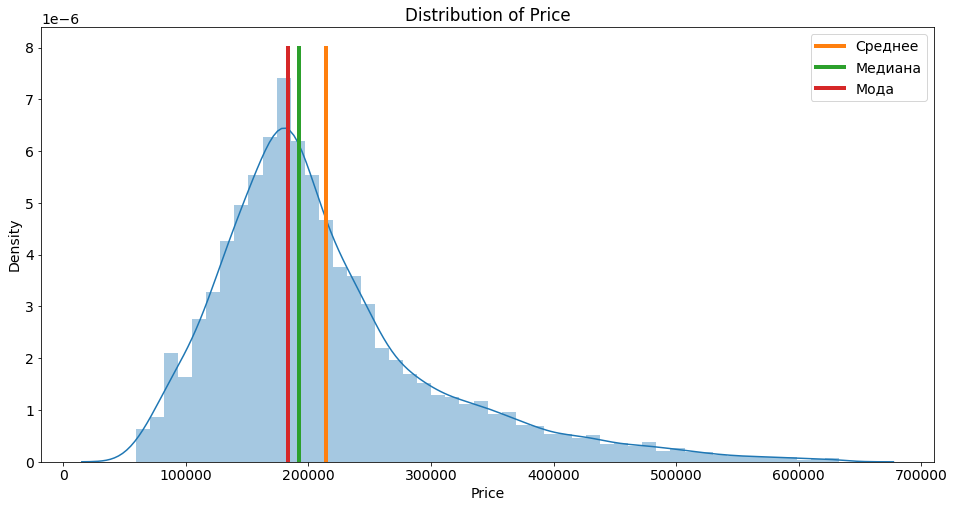

In [13]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000008, 10)
plt.plot([target_mean] * 10, y, label='Среднее',  linewidth=4)
plt.plot([target_median] * 10, y, label='Медиана',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Мода', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

### Анализ признаков

In [14]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

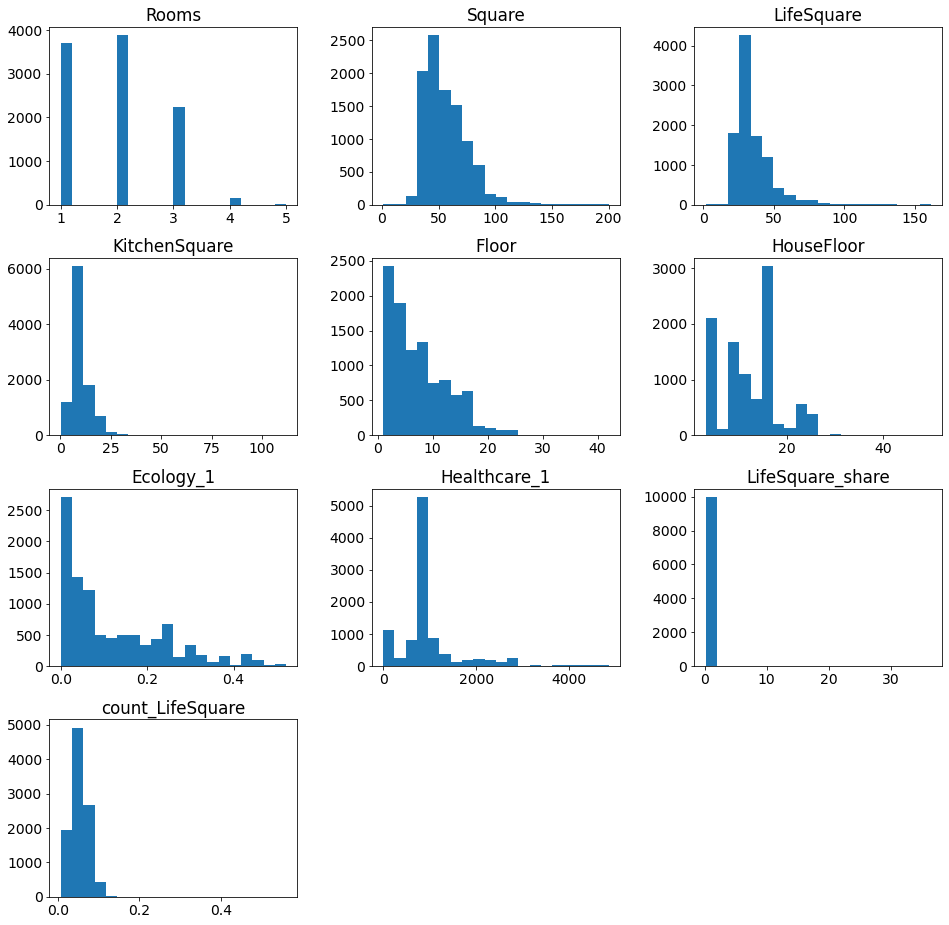

In [15]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

### Зависимость показателей здоровья и экологии

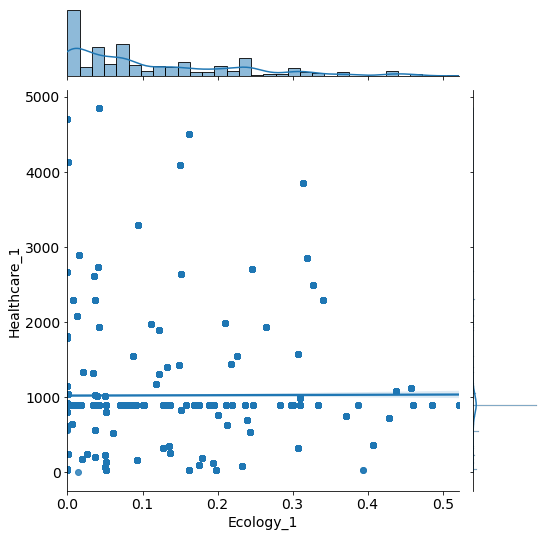

In [16]:
grid = sns.jointplot(df['Ecology_1'], df['Healthcare_1'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### Зависимость комнат от площади

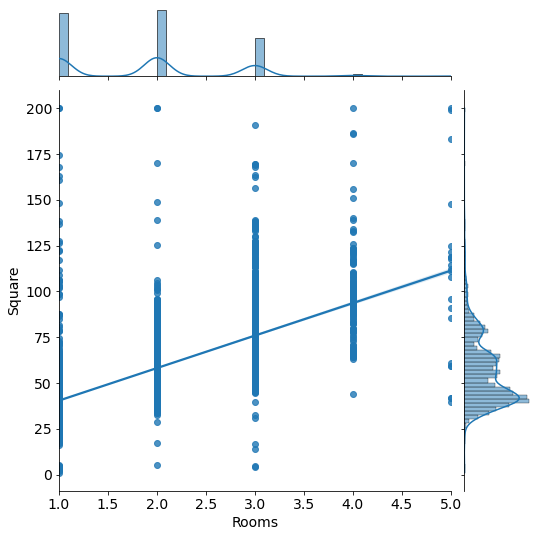

In [17]:
grid = sns.jointplot(df['Rooms'], df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### Категориальные признаки

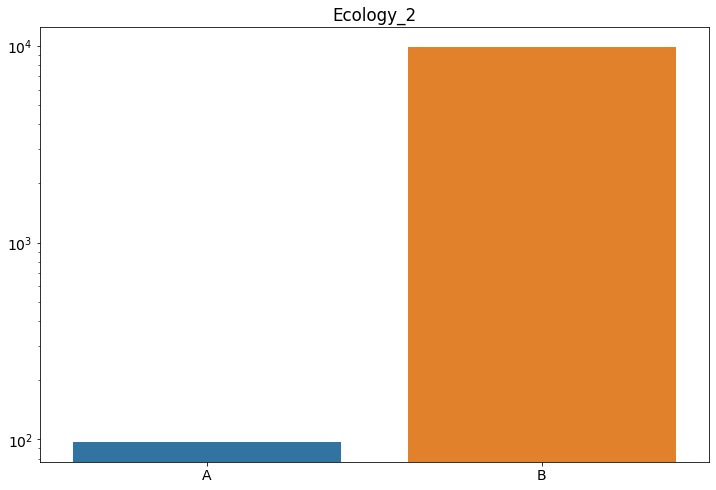

In [18]:
counts = df['Ecology_2'].value_counts()
    
plt.figure(figsize=(12,8))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)
plt.yscale('log')
plt.show()

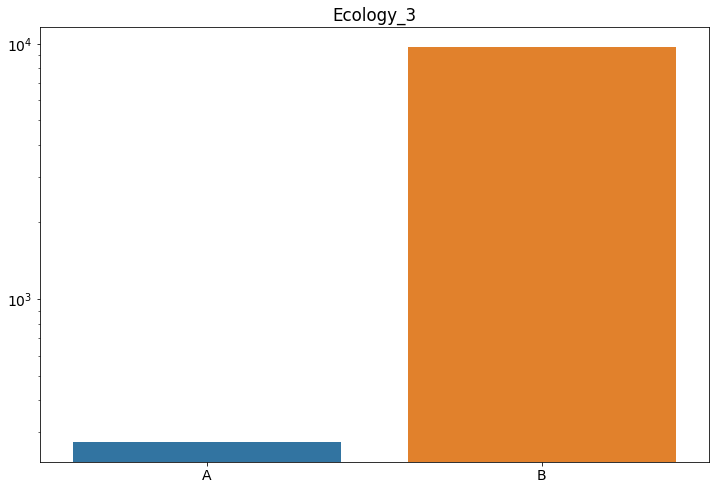

In [19]:
counts = df['Ecology_3'].value_counts()
    
plt.figure(figsize=(12,8))    
plt.title('Ecology_3')
sns.barplot(counts.index, counts.values)
plt.yscale('log')
plt.show()

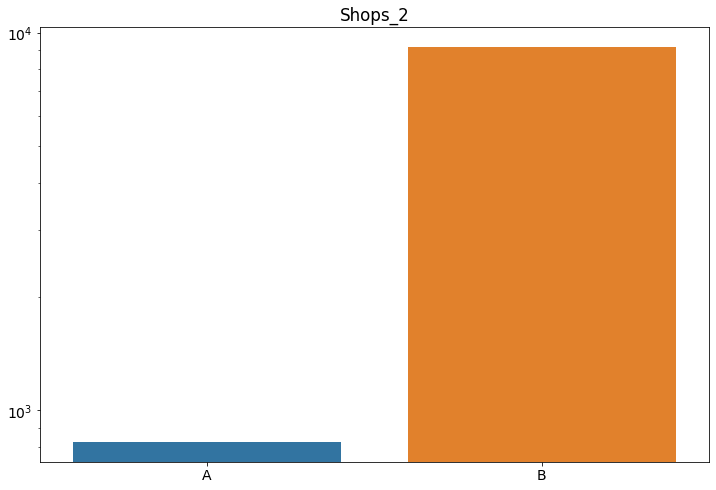

In [20]:
counts = df['Shops_2'].value_counts()
    
plt.figure(figsize=(12,8))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)
plt.yscale('log')    
plt.show()

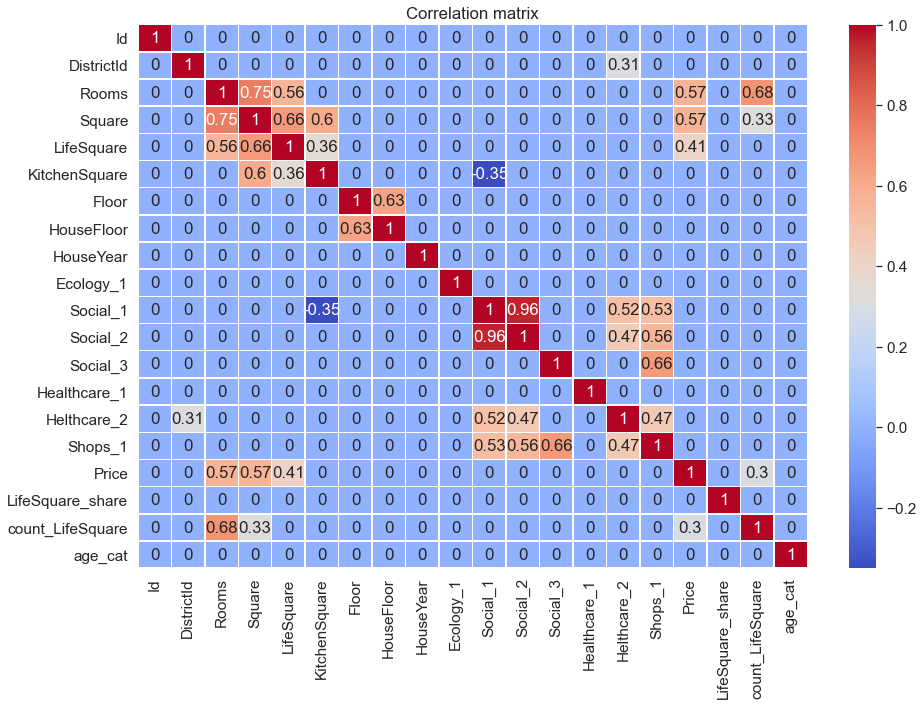

In [21]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [22]:
REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [23]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                 'Ecology_1', 'Social_1',  'Social_2', 'Social_3', 'Healthcare_1', 
                  'Helthcare_2', 'Shops_1', 'LifeSquare_share', 'age_cat', 'count_LifeSquare']
target_name = 'Price'

In [24]:
df = df[feature_names + [target_name]]

In [25]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [26]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

In [27]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

In [28]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [29]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 2min 2s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [30]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [31]:
gs.best_score_

0.7292256696429089

R2:	0.894
RMSE:	29769.64
MSE:	886231466.472


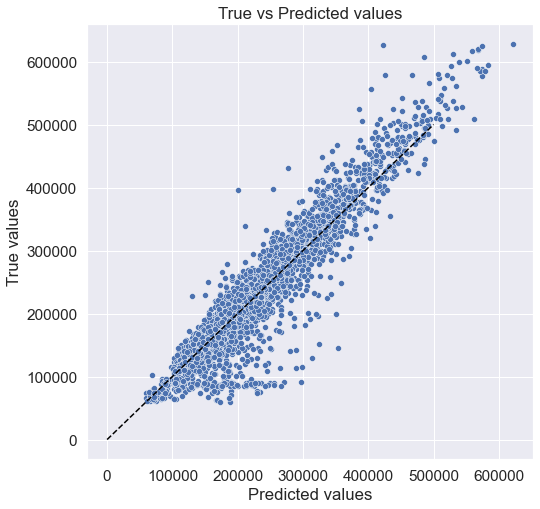

In [32]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=10,
                                        random_state=42,  
                                        n_estimators=200)

final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.723
RMSE:	49520.289
MSE:	2452258993.222


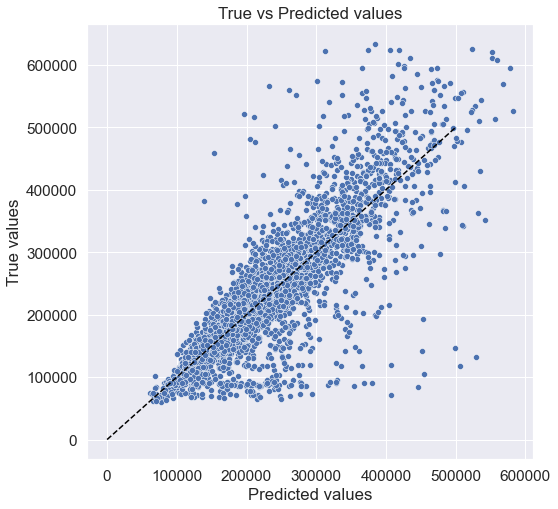

In [33]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save = True)

In [34]:
final_model.feature_importances_

array([0.04548822, 0.0636544 , 0.38651785, 0.02193522, 0.02214233,
       0.01019131, 0.01949059, 0.04923404, 0.08917178, 0.12302945,
       0.07017116, 0.02719887, 0.00556275, 0.01708184, 0.02307075,
       0.01212864, 0.01393081])

In [35]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(3)

,feature_name,importance
2,Square,0.386518
9,Social_2,0.123029
8,Social_1,0.089172


In [36]:
import pickle 

In [37]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [38]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [39]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=10,
                          n_estimators=200, random_state=42)

In [40]:
import sklearn
print(sklearn.__version__)

0.23.2


### обработка test.csv

In [41]:
DATASET_PATH = './test.csv'
PREPARED_DATASET_PATH = './test_prepared.csv'

In [42]:
df1 = pd.read_csv(DATASET_PATH)

pipe = DataPipeline()
pipe.fit(df1)
df1 = pipe.transform(df1)
age_to_cat(df1)
df1.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [43]:
df1

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_share,count_LifeSquare,age_cat
0,4567,44,1.0,36.847630,27.635723,5.000000,5.0,9.0,1970,0.036122,...,24,4378,0,1036.0,1,1,B,0.750000,0.036185,4
1,5925,62,1.0,42.493907,41.769526,10.000000,7.0,17.0,2017,0.072158,...,2,629,1,900.0,0,0,A,0.982953,0.023941,1
2,960,27,2.0,59.463678,32.925087,9.000000,19.0,19.0,1977,0.211401,...,9,1892,0,900.0,0,1,B,0.553701,0.060744,4
3,3848,23,3.0,49.646030,33.893825,6.000000,2.0,3.0,1965,0.014073,...,2,475,0,900.0,0,0,B,0.682710,0.088512,4
4,746,74,1.0,53.837056,32.925087,13.459264,8.0,17.0,1977,0.309479,...,35,7715,4,990.0,0,6,B,0.611569,0.030372,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.000000,5.0,5.0,1962,0.069660,...,31,6119,4,900.0,1,2,B,0.702679,0.065920,4
4996,16138,38,3.0,93.698122,41.769526,10.000000,21.0,27.0,2018,0.060753,...,15,2787,2,520.0,0,7,B,0.445788,0.071823,1
4997,3912,101,1.0,33.656723,25.242542,5.000000,2.0,5.0,1966,0.038693,...,28,6533,1,1015.0,2,5,B,0.750000,0.039616,4
4998,5722,10,1.0,38.635155,20.976257,9.000000,8.0,14.0,1970,0.089040,...,33,7976,5,900.0,0,11,B,0.542932,0.047673,4


In [44]:
df1 = reduce_mem_usage(df1)

Memory usage of dataframe is 0.78 MB
Memory usage after optimization is: 0.27 MB
Decreased by 65.2%


In [45]:
feature_names_for_stand = df1[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
scaler = StandardScaler()
stand_features = scaler.fit_transform(df1[feature_names_for_stand])

In [46]:
df1[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df1.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_share,count_LifeSquare,age_cat
0,4567,44,-1.121039,-1.030207,-0.672663,-1.050814,-0.570966,-0.588000,1970,-0.697594,...,24,4378,0,0.008615,1,1,B,0.189803,-0.760895,4
1,5925,62,-1.121039,-0.733323,0.451527,-0.037842,-0.190930,0.660739,2017,-0.397445,...,2,629,1,-0.168811,0,0,A,0.720706,-1.284753,1
2,960,27,0.114130,0.158956,-0.251952,-0.240437,2.089286,0.972924,1977,0.762360,...,9,1892,0,-0.168811,0,1,B,-0.257564,0.289840,4
3,3848,23,1.349298,-0.357261,-0.174899,-0.848219,-1.141020,-1.524555,1965,-0.881250,...,2,475,0,-0.168811,0,0,B,0.036448,1.477863,4
4,746,74,-1.121039,-0.136895,-0.251952,0.662984,-0.000912,0.660739,1977,1.579283,...,35,7715,4,-0.051397,0,6,B,-0.125682,-1.009604,4


In [47]:
df1.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

### Финальные предсказания цены

In [48]:
X = df1[feature_names]
y = df[target_name]

R2:	-0.74
RMSE:	120851.661
MSE:	14605124050.611


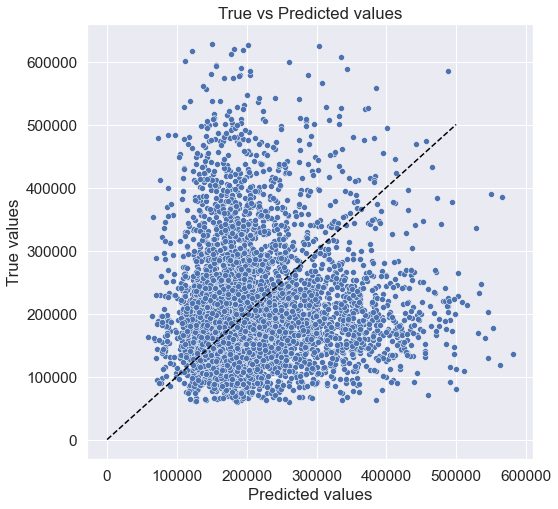

In [49]:
y_train_preds = final_model.predict(X)
evaluate_preds(y_train, y_train_preds)

In [50]:
d = {'Id': df1['Id'], 'Price': y_train_preds}
df2 = pd.DataFrame(data=d)
df2

,Id,Price
0,4567,161520.303234
1,5925,126509.812323
2,960,152770.442632
3,3848,118993.496884
4,746,188214.138977
...,...,...
4995,10379,170116.127123
4996,16138,329506.697541
4997,3912,134054.529823
4998,5722,198293.062458


In [51]:
df2.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')